# Sample: Std dev, and Co, all in Java

First, set the classpath with the right jar. This `jar` contains the statistical functions, system resolution and other linear algebra features, as well as the graphic library we use to display the curves.

This jar is built from the root of this repository, using the following command:
```
$ ./gradlew shadowJar --parallel
```

In [1]:
%classpath add jar "../build/libs/Algebra-1.0-all.jar"

In [2]:
// Verify if the classpath above is taken in account
import matrix.SquareMatrix;
import matrix.SystemUtil;
import smoothing.LeastSquaresMethod;
import stat.StatFunctions;

import gsg.SwingUtils.WhiteBoardPanel;
import gsg.VectorUtils;

import java.util.concurrent.atomic.AtomicInteger;
import java.awt.Color;
import java.awt.Dimension;
import java.awt.Font;

Where we are:

In [3]:
System.out.println(String.format("Running from folder %s", System.getProperty("user.dir")));
System.out.println(String.format("Java version %s", System.getProperty("java.version")));

Running from folder /Users/olivierlediouris/repos/raspberry-coffee/Algebra/jupyter
Java version 11.0.8


Now create a white board, with several non-default options

In [4]:
WhiteBoardPanel whiteBoard = new WhiteBoardPanel();
whiteBoard.setAxisColor(new Color(125, 0, 255, 255));
whiteBoard.setWithGrid(false);
whiteBoard.setBgColor(new Color(250, 250, 250, 255));
whiteBoard.setGraphicTitle(null);
whiteBoard.setDimension(new Dimension(800, 600));
whiteBoard.setTextColor(Color.RED);
whiteBoard.setTitleFont(new Font("Arial", Font.BOLD | Font.ITALIC, 32));
whiteBoard.setGraphicMargins(30);
whiteBoard.setXEqualsY(false);

### Create random data
They are created as `double arrays`, and will be eventually transformed into a `List<VectorUtils.Vector2D>`, to be easilly managed by the white board. This could be done all in one step, we proceed like this for clarity.

In [5]:
double previousY = 10d;  // Y starts here
double yAmpl = 20d;      // Y amplitude
List<Double> xs = new ArrayList<>();
List<Double> ys = new ArrayList<>();
for (double x=0; x<501; x++) {
  xs.add(x);
  double delta = Math.random() - 0.5;  // [-0.5, 0.5]
  // delta *= yAmpl;
  double nextY = previousY + delta;
  if (nextY > yAmpl || nextY < 0) {
    nextY = previousY - delta;
  }
  ys.add(nextY);
  previousY = nextY;
}

double[] xData = xs.stream()
                   .mapToDouble(Double::doubleValue)
                   .toArray();
double[] yData = ys.stream()
                   .mapToDouble(Double::doubleValue)
                   .toArray();
                   
List<VectorUtils.Vector2D> dataVectors = new ArrayList<>();
for (int i=0; i<xData.length; i++) {
  dataVectors.add(new VectorUtils.Vector2D(xData[i], yData[i]));
}

Shape the data (color, line thickness, graphic type), add them to the white board, and trigger the display.

In [6]:
WhiteBoardPanel.DataSerie dataSerie = new WhiteBoardPanel.DataSerie()
                            .data(dataVectors)
                            .graphicType(WhiteBoardPanel.GraphicType.LINE)
                            .lineThickness(3)
                            .color(Color.BLUE);
whiteBoard.addSerie(dataSerie);

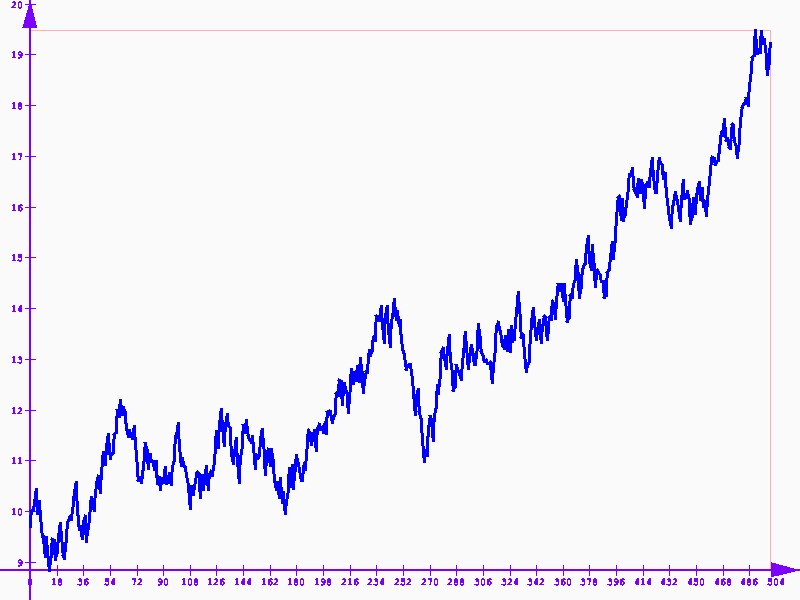

In [7]:
whiteBoard.getImage();

Use linear regression to find the line (dimension 1) closest to the data points.
- Step 1, populate the matrix elements

In [8]:
// Linear Regression
final int REQUIRED_SMOOTHING_DEGREE = 1;
int dimension = REQUIRED_SMOOTHING_DEGREE + 1;
double[] sumXArray = new double[(REQUIRED_SMOOTHING_DEGREE * 2) + 1]; // Will fill the matrix
double[] sumY      = new double[REQUIRED_SMOOTHING_DEGREE + 1];
// init
for (int i=0; i<((REQUIRED_SMOOTHING_DEGREE * 2) + 1); i++) {
  sumXArray[i] = 0.0;
}
for (int i=0; i<(REQUIRED_SMOOTHING_DEGREE + 1); i++) {
  sumY[i] = 0.0;
}
List<LeastSquaresMethod.Tuple> data = new ArrayList<>();
for (int x=0; x<xData.length; x++) {
    data.add(new LeastSquaresMethod.Tuple(xData[x], yData[x]));
}
data.stream().forEach(tuple -> {
  for (int i=0; i<((REQUIRED_SMOOTHING_DEGREE * 2) + 1); i++) {
    sumXArray[i] += Math.pow(tuple.getX(), i);
  }
  for (int i=0; i<(REQUIRED_SMOOTHING_DEGREE + 1); i++) {
    sumY[i] += (tuple.getY() * Math.pow(tuple.getX(), i));
  }
});

- Step 2, resolve the system

In [9]:
SquareMatrix squareMatrix = new SquareMatrix(dimension);
for (int row=0; row<dimension; row++) {
  for (int col=0; col<dimension; col++) {
    int powerRnk = (REQUIRED_SMOOTHING_DEGREE - row) + (REQUIRED_SMOOTHING_DEGREE - col);
    System.out.println("[" + row + "," + col + ": deg " + (powerRnk) + "] = " + sumXArray[powerRnk]);
    squareMatrix.setElementAt(row, col, sumXArray[powerRnk]);
  }
}
double[] constants = new double[dimension];
for (int i=0; i<dimension; i++) {
  constants[i] = sumY[REQUIRED_SMOOTHING_DEGREE - i];
  System.out.println("[" + (REQUIRED_SMOOTHING_DEGREE - i) + "] = " + constants[i]);
}

System.out.println("Resolving:");
SystemUtil.printSystem(squareMatrix, constants);
System.out.println();

double[] result = SystemUtil.solveSystem(squareMatrix, constants);

[0,0: deg 2] = 4.179175E7
[0,1: deg 1] = 125250.0
[1,0: deg 1] = 125250.0
[1,1: deg 0] = 501.0
[1] = 1802030.239879228
[0] = 6541.260725086824
Resolving:
(41791750.000000 x A) + (125250.000000 x B) = 1802030.239879
(125250.000000 x A) + (501.000000 x B) = 6541.260725



Resolution Completed, displaying results.

In [10]:
AtomicInteger integer = new AtomicInteger(0);
// Final equation coefficients:
Arrays.stream(result)
      .boxed()
      .map(coef -> new LeastSquaresMethod.IndexedCoeff(integer.incrementAndGet(), coef))
      .forEach(ic -> System.out.println(String.format("Deg %d -> %f", (dimension - ic.getIdx()), ic.getCoef())));

Deg 1 -> 0.015909
Deg 0 -> 9.079143


_**Calculate Standard Deviation**_

In [11]:
double std = StatFunctions.standardDeviation(yData);
System.out.println(String.format("Standard Deviation: %f", std));

Standard Deviation: 2.460113


Display data, with linear regression, top and bottom (plus and minus std-dev).
- Step 1, create the data representing the lines

In [12]:
List<Double> ySmoothed = new ArrayList<>();

xs.forEach(x -> {
  double y = (x * result[0]) + result[1];
  ySmoothed.add(y);
});

double[] yDataSmoothed = ySmoothed.stream()
                   .mapToDouble(Double::doubleValue)
                   .toArray();
double[] top = ySmoothed.stream()
                   .mapToDouble(d -> d.doubleValue() + std)
                   .toArray();
double[] bottom = ySmoothed.stream()
                   .mapToDouble(d -> d.doubleValue() - std)
                   .toArray();

- Step 2, create the lists of vectors

In [13]:
List<VectorUtils.Vector2D> centerVectors = new ArrayList<>();
for (int i=0; i<xData.length; i++) {
  centerVectors.add(new VectorUtils.Vector2D(xData[i], yDataSmoothed[i]));
}

List<VectorUtils.Vector2D> topVectors = new ArrayList<>();
for (int i=0; i<xData.length; i++) {
  topVectors.add(new VectorUtils.Vector2D(xData[i], top[i]));
}

List<VectorUtils.Vector2D> bottomVectors = new ArrayList<>();
for (int i=0; i<xData.length; i++) {
  bottomVectors.add(new VectorUtils.Vector2D(xData[i], bottom[i]));
}

- Step 3, add the newly created data to the previous graphic, and display them!

In [14]:
WhiteBoardPanel.DataSerie centerSerie = new WhiteBoardPanel.DataSerie()
                            .data(centerVectors)
                            .graphicType(WhiteBoardPanel.GraphicType.LINE)
                            .lineThickness(3)
                            .color(Color.RED);
whiteBoard.addSerie(centerSerie);

WhiteBoardPanel.DataSerie topSerie = new WhiteBoardPanel.DataSerie()
                            .data(topVectors)
                            .graphicType(WhiteBoardPanel.GraphicType.LINE)
                            .lineThickness(3)
                            .color(Color.YELLOW);
whiteBoard.addSerie(topSerie);

WhiteBoardPanel.DataSerie bottomSerie = new WhiteBoardPanel.DataSerie()
                            .data(bottomVectors)
                            .graphicType(WhiteBoardPanel.GraphicType.LINE)
                            .lineThickness(3)
                            .color(Color.GREEN);
whiteBoard.addSerie(bottomSerie);

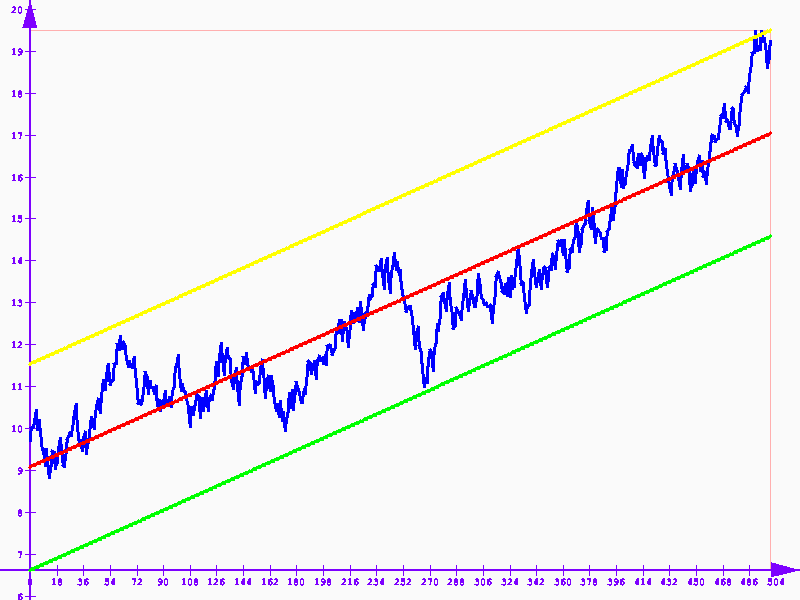

In [15]:
whiteBoard.getImage(); // Show!

---